### How to load the data

This jupyter notebook demonstrates how to access the data of the dataset. To run the notebook you will need to install the following packages:
- pymef (to read MEF3 format)
- pybids (to load the BIDS data structure)


Let's do the imports first

In [358]:
import os

from pymef import MefSession
from bids import BIDSLayout

import numpy as np
import matplotlib.pyplot as plt


Now load the BIDS dataset

In [359]:
path_to_dataset = r"C:\MasterThesis\v1.0"  # Please change this value

l = BIDSLayout(path_to_dataset)

Define what data we want to load

In [360]:
subject = '012'
run = 4
filter_dictionary = {'subject': subject,
                     'session': '001',
                     'task': 'FR',
                     'run': run,
                     'suffix': 'ieeg',
                     'extension': 'json'}
json_files = l.get(**filter_dictionary)

# We now we have requested only one file now but multiple files can be processed in a for loop
json_file = json_files[0]
print(json_file)

json_entities = json_file.entities

<BIDSJSONFile filename='C:\MasterThesis\v1.0\sub-012\ses-001\ieeg\sub-012_ses-001_task-FR_run-04_ieeg.json'>


Load information about channels

In [361]:
# Get channels
channel_file = l.get(suffix='channels', extension='tsv',
                     task=json_entities['task'],
                     subject=json_entities['subject'],
                     session=json_entities['session'],
                     run=json_entities['run'])[0]
channel_df = channel_file.get_df()
channel_df = channel_df[channel_df['status'] != 'bad']
channel_df
    

,name,type,units,low_cutoff,high_cutoff,reference,sampling_frequency,status,status_description
0,LA_01,SEEG,µV,0.1,200.0,scalp_cpz,32000,good,NaN
1,LA_02,SEEG,µV,0.1,200.0,scalp_cpz,32000,good,NaN
2,LA_03,SEEG,µV,0.1,200.0,scalp_cpz,32000,good,NaN
3,LA_04,SEEG,µV,0.1,200.0,scalp_cpz,32000,good,NaN
4,LA_05,SEEG,µV,0.1,200.0,scalp_cpz,32000,good,NaN
...,...,...,...,...,...,...,...,...,...
132,RZ_14,SEEG,µV,0.1,200.0,scalp_cpz,32000,good,NaN
133,RZ_15,SEEG,µV,0.1,200.0,scalp_cpz,32000,good,NaN
134,RZ_16,SEEG,µV,0.1,200.0,scalp_cpz,32000,good,NaN
135,SCREEN_X,EYEGAZE,px,NaN,NaN,scalp_cpz,150,good,NaN


Load events

In [362]:
events_file = l.get(suffix='events', extension='tsv',
                    task=json_entities['task'],
                    subject=json_entities['subject'],
                    session=json_entities['session'],
                    run=json_entities['run'])[0]
events_df = events_file.get_df()

# Pull only the processed events (discarding the original events)
events_df = events_df.loc[~events_df['trial_type'].isna(), ['onset', 'sample', 'duration', 'trial_type', 'list']]
events_df = events_df[events_df['trial_type'] == 'ENCODE']
events_df = events_df.reset_index(drop=True)
events_df


,onset,sample,duration,trial_type,list
0,78.870266,2523848,1.489062,ENCODE,1.0
1,81.364234,2603655,1.495093,ENCODE,1.0
2,83.865733,2683703,1.493593,ENCODE,1.0
3,86.365888,2763708,1.493468,ENCODE,1.0
4,88.864856,2843675,1.494561,ENCODE,1.0
...,...,...,...,...,...
175,1499.685977,47989951,1.485968,ENCODE,15.0
176,1502.177694,48069686,1.493968,ENCODE,15.0
177,1504.683475,48149871,1.488186,ENCODE,15.0
178,1507.178286,48229705,1.493468,ENCODE,15.0


Now load the raw data

In [363]:
# Since we are using MEF3 pybids has problems recognizing the extension so we need to modify the json extension
mef_session_path = os.path.splitext(json_file.path)[0]+'.mefd'
print(mef_session_path)
ms = MefSession(mef_session_path, None)
ms.read_ts_channel_basic_info()

C:\MasterThesis\v1.0\sub-012\ses-001\ieeg\sub-012_ses-001_task-FR_run-04_ieeg.mefd


[{'name': 'LA_01',
  'fsamp': array([32000.]),
  'nsamp': array([54868370], dtype=int64),
  'ufact': array([0.03051851]),
  'unit': array([b'uV'], dtype='|S128'),
  'start_time': array([1568813375681839], dtype=int64),
  'end_time': array([1568815090318401], dtype=int64),
  'channel_description': array([b'SEEG'], dtype='|S2048')},
 {'name': 'LA_02',
  'fsamp': array([32000.]),
  'nsamp': array([54868370], dtype=int64),
  'ufact': array([0.03051851]),
  'unit': array([b'uV'], dtype='|S128'),
  'start_time': array([1568813375681839], dtype=int64),
  'end_time': array([1568815090318401], dtype=int64),
  'channel_description': array([b'SEEG'], dtype='|S2048')},
 {'name': 'LA_03',
  'fsamp': array([32000.]),
  'nsamp': array([54868370], dtype=int64),
  'ufact': array([0.03051851]),
  'unit': array([b'uV'], dtype='|S128'),
  'start_time': array([1568813375681839], dtype=int64),
  'end_time': array([1568815090318401], dtype=int64),
  'channel_description': array([b'SEEG'], dtype='|S2048')},
 

Now load the data as they are presented in the manuscript Figure 3

In [364]:
channels = ['LEFT_PUPIL_SIZE', 'RIGHT_PUPIL_SIZE']

# Microseconds 1 μs = 10⁻⁶ s
start_time = 1553941347170839+3*1e6  # in microseconds
end_time = 1553942904095135-3*1e6
win_size = 10  # in seconds
stop_time = start_time + int(win_size*1e6)

bi = ms.read_ts_channel_basic_info()

# In this case we are reading MEF records instead of data from events.tsv because we do not have to make time conversions this way
records = ms.read_records()
# print(len(records))
records_in_win = [x for x in records if start_time < x['time'] < stop_time]
# print(len(records_in_win))
# print(records_in_win)
# The code to get corresponding events from the events file
session_metadata = ms.session_md
session_start_utc = session_metadata['session_specific_metadata']['earliest_start_time'][0]
print(f"session_start_utc = {session_start_utc}\nsession_stop_utc = {stop_time}")
events_df['microsecond_onset'] = events_df['onset']*1e6
events_df['uutc'] = (events_df['microsecond_onset'] + session_start_utc).astype('int64')
events_in_win = events_df[(start_time < events_df['uutc'])
                          & (events_df['uutc'] < stop_time)]
events_df.head()

session_start_utc = 1568813375681839
session_stop_utc = 1553941360170839.0


,onset,sample,duration,trial_type,list,microsecond_onset,uutc
0,78.870266,2523848,1.489062,ENCODE,1.0,78870266.0,1568813454552105
1,81.364234,2603655,1.495093,ENCODE,1.0,81364234.0,1568813457046073
2,83.865733,2683703,1.493593,ENCODE,1.0,83865733.0,1568813459547572
3,86.365888,2763708,1.493468,ENCODE,1.0,86365888.0,1568813462047727
4,88.864856,2843675,1.494561,ENCODE,1.0,88864856.0,1568813464546695


In [365]:
# records_in_events = [x for x in records if (0 < (x['time'] - events_df['uutc']) < 150000)]
records_in_events = []
for x in records:
    for e in events_df['uutc']:
        # print(x['time'] - e)
        if 0 == (x['time'] - e):
            records_in_events.append(x)

len(records_in_events)
data_events = []
for e in events_df['uutc']:
    data_events.append(ms.read_ts_channels_uutc(channels, [e - 500000, e + 1000000]))
len(data_events)

180

In [366]:
print(data_events[0])

[array([4.57697399e+08, 4.55002500e+08, 4.55206400e+08, 4.56505200e+08,
       4.47627600e+08, 4.48415500e+08, 4.46367199e+08, 4.56593800e+08,
       4.51815000e+08, 4.51973100e+08, 4.48638400e+08, 4.42285899e+08,
       4.44626999e+08, 4.40827200e+08, 4.39062399e+08, 4.37426999e+08,
       4.35820499e+08, 4.40450000e+08, 4.33464500e+08, 4.36244000e+08,
       4.33884000e+08, 4.32326299e+08, 4.34788800e+08, 4.33079700e+08,
       4.34410800e+08, 4.30525200e+08, 4.28649000e+08, 4.27213600e+08,
       4.25332000e+08, 4.24316000e+08, 4.24316000e+08, 4.25369699e+08,
       4.22624000e+08, 4.24647200e+08, 4.28188799e+08, 4.26114300e+08,
       4.25510800e+08, 4.19739300e+08, 4.18469100e+08, 4.21916000e+08,
       4.19601000e+08, 4.15500000e+08, 4.15967600e+08, 4.13575200e+08,
       4.18488000e+08, 4.11810000e+08, 4.08771800e+08, 4.12068300e+08,
       4.11894000e+08, 4.06308700e+08, 4.10732799e+08, 4.05495600e+08,
       4.11366900e+08, 4.08700800e+08, 4.08700800e+08, 4.08084000e+08,
     

## Apply linear interpolation if values are missing

In [367]:
import numpy as np

def check_missing_values(arr):
    """Check if a numpy array has missing values."""
    if np.isnan(arr).any():
        print("The array has missing values.")
        return True
    else:
        return False

In [368]:
import pandas as pd

how_many_nan = 0
for s_idx, sequence in enumerate(data_events):
    for ch_idx, channel in enumerate(sequence):
        if check_missing_values(channel):
            how_many_nan += 1
            df = pd.DataFrame({'signal': channel})
            print(f"Apply linear interpolation to fill the missing values [{s_idx}][{ch_idx}]")
            df['signal'] = df['signal'].bfill().ffill().interpolate(method='linear')
            data_events[s_idx][ch_idx] = df['signal'].values.tolist()
            print(data_events[s_idx][ch_idx])
print(how_many_nan)

The array has missing values.
Apply linear interpolation to fill the missing values [0][0]
[457697399.0, 455002500.0, 455206400.0, 456505200.0, 447627600.0, 448415500.0, 446367199.0, 456593800.0, 451815000.0, 451973100.0, 448638400.0, 442285899.0, 444626999.0, 440827200.0, 439062399.0, 437426999.0, 435820499.0, 440450000.0, 433464500.0, 436244000.0, 433884000.0, 432326299.0, 434788800.0, 433079700.0, 434410800.0, 430525200.0, 428649000.0, 427213600.0, 425332000.0, 424316000.0, 424316000.0, 425369699.0, 422624000.0, 424647200.0, 428188799.0, 426114300.0, 425510800.0, 419739300.0, 418469100.0, 421916000.0, 419601000.0, 415500000.0, 415967600.0, 413575200.0, 418488000.0, 411810000.0, 408771800.0, 412068300.0, 411894000.0, 406308700.0, 410732799.0, 405495600.0, 411366900.0, 408700800.0, 408700800.0, 408084000.0, 405217599.0, 407372900.0, 406744800.0, 406744800.0, 402695500.0, 405924300.0, 403467200.0, 400513100.0, 400064400.0, 397702800.0, 401099700.0, 396960799.0, 394399500.0, 398704500.0

## Apply low pass filter

In [369]:
import numpy as np
from scipy.signal import butter, filtfilt

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# Parameters
order = 3
fs = 150.0       # sample rate, Hz
cutoff = 30.0    # desired cutoff frequency of the filter, Hz


## Plot the window

In [370]:
def plot_channels(data):
    # %% Plot
    f, ax_arr = plt.subplots(len(channels),
                             gridspec_kw={'hspace': 0.0}, sharex=True,
                             figsize=(12, 9))

    for ax, ch, ch_data in zip(ax_arr, channels, data[10]):

        detrended_data = ch_data - np.nanmean(ch_data)
        # Pupil size channels
        if 'PUPIL' in ch:
            detrended_data *= np.pi
            detrended_data = detrended_data / 3000000

        fs = [x for x in bi if x['name'] == ch][0]['fsamp'][0]
        unit = [x for x in bi if x['name'] == ch][0]['unit'][0]

        plt.sca(ax)
        length = 1.5
        x = np.arange(0, length, 1/fs)
        plt.plot(x, detrended_data, label=ch, color='k')

        ax.annotate(ch, xy=(12, 88), xycoords='axes points',
                    size=12,
                    ha='left', va='top',
                    bbox=dict(boxstyle='round', fc='w'))

        # Pupil size channels
        if 'PUPIL' in ch:
            ax.set_ylim((-0.15*10e2, 0.15*10e2))

        # Take care of records
        y_lim = ax.get_ylim()
        for rec in records_in_events:
            # Determine the sample

            samp = (rec['time'] - start_time)/1e6
            plt.plot([samp, samp], y_lim, 'k--')

            # if ch == channels[0]:
            #     ax.annotate(rec['text'], xy=(samp, y_lim[1]),
            #                 size=12, va='top',
            #                 xytext=(5, -5), textcoords='offset points')

        ax.set_ylim(y_lim)
        ax.tick_params(axis='both', which='major', labelsize=12)

    plt.xlim((0, length))
    plt.xlabel('Time [s]', fontsize=12)

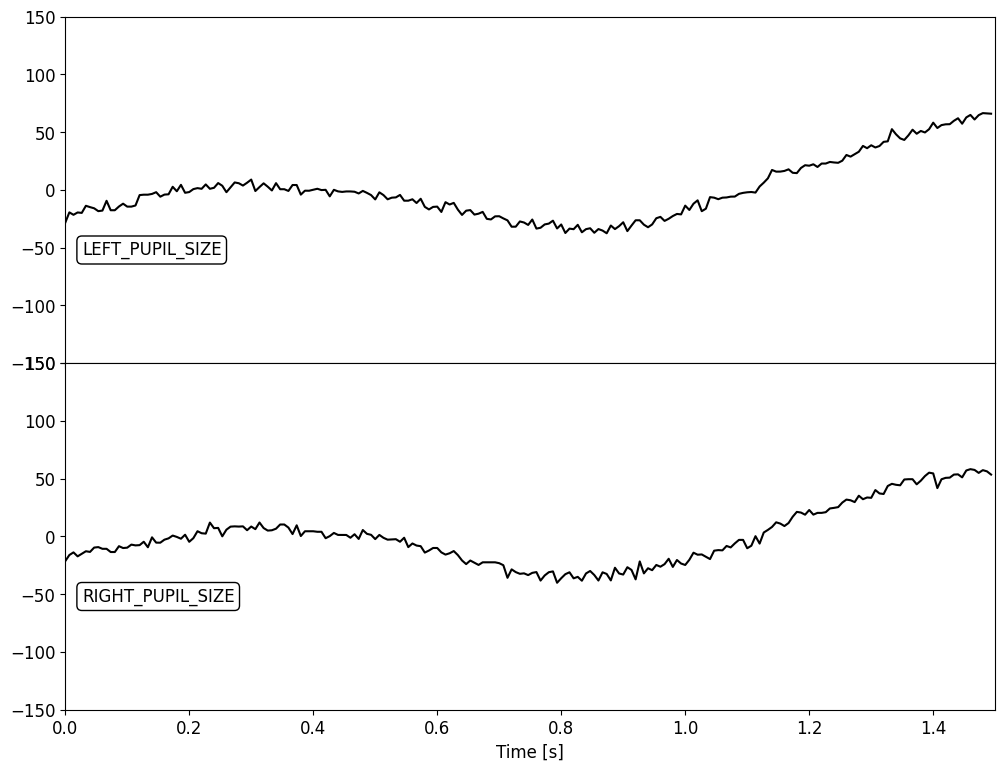

In [371]:
plot_channels(data_events)

In [372]:
# Apply butterworth filter

for s_idx, sequence in enumerate(data_events):
    for ch_idx, channel in enumerate(sequence):
        y = butter_lowpass_filter(channel, cutoff, fs, order)
        data_events[s_idx][ch_idx] = y

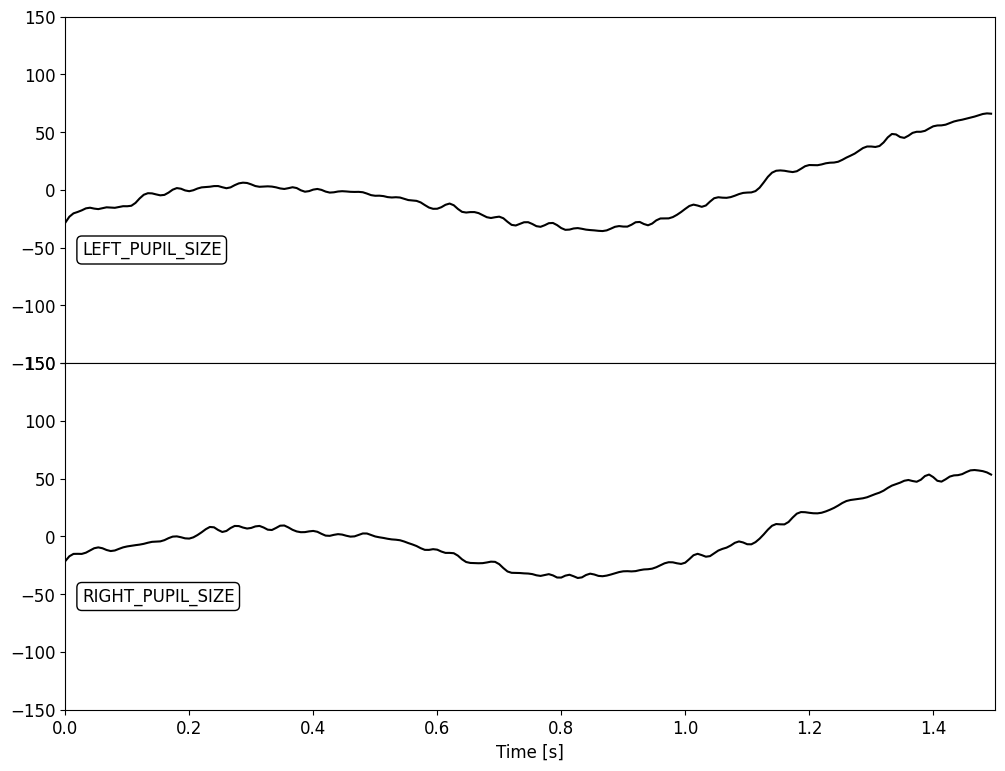

In [373]:
plot_channels(data_events)

## Z-SCORE normalization

In [374]:
for s_idx, sequence in enumerate(data_events):
    for ch_idx, channel in enumerate(sequence):
        mean_pupil_size = np.mean(channel)
        std_pupil_size = np.std(channel)
        # Normalizacja z-score
        normalized_pupil_sizes = [(x - mean_pupil_size) / std_pupil_size for x in channel]
        print(normalized_pupil_sizes)
        data_events[s_idx][ch_idx] = normalized_pupil_sizes

[1.9509944638018364, 1.9220998089974446, 1.875831970210957, 1.7859097903938201, 1.6711178839897622, 1.612667325205066, 1.6622128016508697, 1.7622951993603981, 1.8028811720590439, 1.7372149575271532, 1.6117973552737954, 1.498244461806191, 1.4213430103581204, 1.3589559922973227, 1.296801303352411, 1.2521382054238954, 1.236429307108964, 1.2275987927760914, 1.1985729833500487, 1.151702559179371, 1.1118507951795296, 1.0993594555179558, 1.1108241867777262, 1.1178571778438393, 1.0898841249266813, 1.0222720950119932, 0.9383470231273301, 0.8661079003061257, 0.8189962266768316, 0.7933027435102921, 0.775862949321059, 0.7630412325483334, 0.7734823712749006, 0.8195478030157771, 0.866271176449317, 0.8535549357439791, 0.7700026401399913, 0.675444050405368, 0.6289245410621928, 0.6161927834926926, 0.5834599973984184, 0.5241989863058543, 0.4805034964391925, 0.4648104633707039, 0.43834562070987365, 0.3806324773327194, 0.32477499447666264, 0.2970368718065218, 0.2764692099511513, 0.24307678537804092, 0.216

## Feature extraction

In [375]:
import scipy.fft

for s_idx, sequence in enumerate(data_events):
    for ch_idx, channel in enumerate(sequence):
        eeg_data = channel
       # Calculate Mean of the signal as a feature
        mean = np.mean(eeg_data)

        # Calculate Variance of the signal as a feature
        variance = np.var(eeg_data)

        # Calculate Standard Deviation of the signal as a feature
        std_dev = np.std(eeg_data)

        # Use Fast Fourier Transform to get the power spectrum of the signal
        power_spectrum = np.abs(scipy.fft.fft(eeg_data))**2

        # Frequency values for plotting the spectrum - assuming a sampling rate (fs) of 128 Hz
        freqs = scipy.fft.fftfreq(len(eeg_data), 1 / 128)

        # Let's use the mean power in specific frequency bands as features
        delta_power = np.mean(power_spectrum[(freqs >= 0.5) & (freqs <= 4)])
        theta_power = np.mean(power_spectrum[(freqs > 4) & (freqs <= 8)])
        alpha_power = np.mean(power_spectrum[(freqs > 8) & (freqs <= 12)])
        beta_power = np.mean(power_spectrum[(freqs > 12) & (freqs <= 30)])

        # Gather all features into a list
        features = [mean, variance, std_dev, delta_power, theta_power, alpha_power, beta_power]

        print("Extracted features:", features)
        data_events[s_idx][ch_idx] = features
print(len(data_events))
print(len(data_events[0]))
print(len(data_events[0][0]))

Extracted features: [2.210577400142534e-15, 1.0000000000000002, 1.0, 3302.5340430146653, 130.13670281251734, 48.99875471827811, 29.55364617264954]
Extracted features: [2.1789977229976404e-15, 0.9999999999999998, 0.9999999999999999, 3011.434686588926, 169.41664027159382, 111.32427444370396, 71.45135467215898]
Extracted features: [4.2948360917054945e-15, 1.0, 1.0, 3350.799219593836, 91.03676922855229, 63.921312566694105, 22.731180949776324]
Extracted features: [-1.1131836193574903e-14, 1.0, 1.0, 2502.2928309495205, 500.22507210437027, 240.61863421786316, 69.60640948960457]
Extracted features: [-1.8947806286936005e-15, 1.0, 1.0, 3536.742119820204, 39.46223371481474, 11.861608007018363, 4.719475770061667]
Extracted features: [-2.210577400142534e-15, 1.0, 1.0, 3515.933616810718, 51.041320029370844, 13.717961292386775, 5.714391840499505]
Extracted features: [-2.3368961087221073e-15, 1.0, 1.0, 3444.6970777893666, 82.98665147754782, 23.541843547048426, 10.009592171188775]
Extracted features: [

## Reshape to dataframe

In [376]:
arr = np.array(data_events)

# Reshape the array to the required shape (180, 450)
arr_reshaped = arr.reshape(180, -1)  # -1 means calculate the size of this dimension

# Convert the reshaped array to a DataFrame
df = pd.DataFrame(arr_reshaped)

# Now df is a DataFrame with shape (180, 450)
print(df.shape)

(180, 14)


In [377]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,2.210577e-15,1.0,1.0,3302.534043,130.136703,48.998755,29.553646,2.178998e-15,1.0,1.0,3011.434687,169.416640,111.324274,71.451355
1,4.294836e-15,1.0,1.0,3350.799220,91.036769,63.921313,22.731181,-1.113184e-14,1.0,1.0,2502.292831,500.225072,240.618634,69.606409
2,-1.894781e-15,1.0,1.0,3536.742120,39.462234,11.861608,4.719476,-2.210577e-15,1.0,1.0,3515.933617,51.041320,13.717961,5.714392
3,-2.336896e-15,1.0,1.0,3444.697078,82.986651,23.541844,10.009592,3.157968e-16,1.0,1.0,3471.127714,81.376598,21.918125,6.420726
4,4.231677e-15,1.0,1.0,3411.984846,96.594447,34.851721,11.711246,-1.894781e-16,1.0,1.0,3314.007370,142.852532,39.548804,19.088796


In [378]:
df.to_csv(rf'C:\MasterThesis\v1.0\sub-{subject}\ses-001\{subject}_{run}_pupil_dataset.csv', index=False)